In [1]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
tnqe1 = GenSubspace(chemical_data, 6, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-6), thresh="projection", eps=1e-12);

tnqe1.ord_list = [randperm(tnqe1.chem_data.N_spt) for j=1:tnqe1.mparams.M]

6-element Vector{Vector{Int64}}:
 [3, 7, 1, 6, 2, 5, 4]
 [7, 1, 4, 6, 5, 3, 2]
 [6, 3, 1, 5, 7, 2, 4]
 [4, 5, 6, 2, 3, 7, 1]
 [2, 7, 4, 1, 5, 3, 6]
 [4, 5, 2, 6, 3, 7, 1]

In [4]:
# Generate the permutation operators:

GenPermOps!(tnqe1, compute_alternates=false, verbose=true)

Generating permutation operators:
Progress: [15/15] 
Done!



Generating states:
Progress: [6/6] 
Done!
Minimum eigenvalue: -83.83324948828238
Condition number: 4.358955512912864e7
FCI energy: -75.01927599660624
Final energy estimate: -74.99222931927146
Best single ref. estimate: -74.99121642733691
Error: 0.02704667733478061
BSRfE: 0.028059569269331064
Improvement: 0.0010128919345504528
Percentage error reduction: 3.609791457695459
Eigenvalue condition numbers: [0.0119, 0.0123, 0.0124, 0.0124, 0.0125, 0.0217]
Percent correlation energy with single-geometry DMRG: 51.70873851425848
Percent correlation energy with multi-geometry TNQE: 53.45195234618415


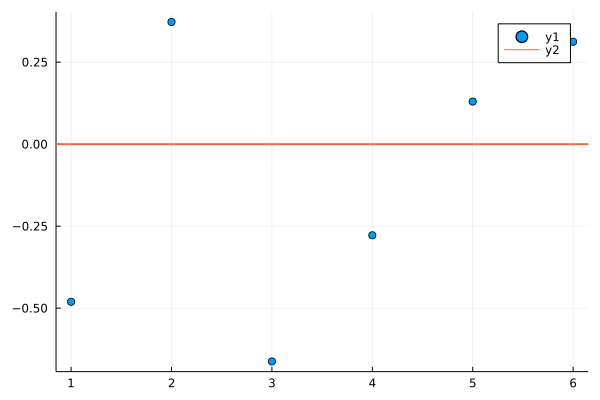

In [5]:
# Initialize the states:
opt_sweeps = Sweeps(15)
maxdim!(opt_sweeps,tnqe1.mparams.psi_maxdim)
mindim!(opt_sweeps,tnqe1.mparams.psi_maxdim)
cutoff!(opt_sweeps,1e-12)
setnoise!(opt_sweeps, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

GenStates!(tnqe1, sweeps=opt_sweeps, verbose=true);
GenSubspaceMats!(tnqe1, verbose=true)
SolveGenEig!(tnqe1, thresh="inversion", eps=1e-8, verbose=true)

In [6]:
function CoGeomOptim!(
        sdata::SubspaceProperties; 
        sweeps=1,
        maxiter=20,
        mg_maxiter=8000,
        method="geneig",
        swap_mult = 0.5,
        alpha=1e-3,
        stun=true,
        gamma=1e2,
        noise=[0.0],
        thresh="inversion",
        eps=1e-8,
        restrict_svals=false,
        costfunc="energy",
        theta=[1.0,1.0,1.0,1.0],
        anchor=false,
        verbose=false
    )
    
    N = sdata.chem_data.N_spt
    M = sdata.mparams.M
    
    # Initialize the cost function:
    f = sdata.E[1]
    f_best = f
    
    for l=1:maxiter
        
        if verbose
            println("\nLoop $(l) of $(maxiter):")
        end
        
        if l > length(noise)
            ns = noise[end]
        else
            ns = noise[l]
        end
        
        # Make a copy of the sdata:
        new_sdata = copy(sdata)
        
        new_ord_list = deepcopy(new_sdata.ord_list)
    
        # Try permuting each ordering in the list:
        for (j,ord) in enumerate(new_ord_list)
            
            # Number of applied swaps to generate a new ordering (sampled from an exponential distribution):
            num_swaps = Int(floor(swap_mult*randexp()[1]))

            # Apply these swaps randomly:
            for swap=1:num_swaps
                p = rand(1:N-1)
                ord[p:p+1]=reverse(ord[p:p+1])
            end
            
        end
        
        # Re-generate the permutation operators:
        UpdatePermOps!(new_sdata, new_ord_list)
        new_sdata.ord_list = new_ord_list
        
        # Optimize the states:
        MultiGeomOptim!(
            new_sdata, 
            sweeps=sweeps, 
            method=method,
            maxiter=mg_maxiter,
            noise=[ns],
            thresh=thresh,
            eps=eps,
            restrict_svals=restrict_svals,
            costfunc=costfunc,
            theta=theta,
            verbose=verbose
        )
        
        GenSubspaceMats!(new_sdata)
        SolveGenEig!(new_sdata)
        
        # New cost function:
        f_new = new_sdata.E[1]
        
        # Accept move with some probability
        beta = alpha*l/maxiter

        if stun
            F_0 = Fstun(f_best, f, gamma)
            F_1 = Fstun(f_best, f_new, gamma)
            P = ExpProb(F_1, F_0, beta)
        else
            P = ExpProb(f, f_new, beta)
        end
        
        #println(f)
        #println(f_new)
        #println(P)

        if f_new < f_best
            f_best = f_new
        end

        if rand()[1] < P
            # Accept move:
            sdata = new_sdata
            f = f_new
            if verbose
                println("\nAccept!")
            end
        else
            if verbose
                println("\nReject!")
            end
        end
        
        
    end
    
    
end

CoGeomOptim! (generic function with 1 method)

In [ ]:
CoGeomOptim!(
    tnqe1, 
    sweeps=2,
    maxiter=20,
    method="geneig",
    swap_mult = 0.3,
    alpha=1e4,
    stun=true,
    gamma=1e2,
    noise=[1e-3],
    thresh="inversion",
    eps=1e-8,
    restrict_svals=true,
    costfunc="energy",
    anchor=false,
    verbose=true
)